In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'basic_lr1e-3_epoch300_resnet50_encoder_soft_aug_k_1'
data_conf

{'conf_name': 'basic_lr1e-3_epoch300_resnet50_encoder_soft_aug_k_1',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': (slice(None, None, None),
  

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'SGD'
optimizer_config['lr'] = 1e-3
optimizer_config['weight_decay'] = 1e-5
optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'SGD',
 'lr': 0.001,
 'weight_decay': 0.0001,
 'amsgrad': False,
 'nesterov': True,
 'momentum': 0.9,
 'centered': False}

In [14]:
aug_config['k'] = 1
aug_config

{'aug_type': 'medium', 'original_height': 128, 'original_width': 128, 'k': 1}

In [15]:
loss_config =[
    {'loss': 'BCE', 'weight': 1, 'params': {}},
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {}}]

In [16]:
data_conf['patches']

{'train': (128, 128, 1), 'val': (128, 128, 1), 'test': (128, 128, 1)}

## Prepare train, validation and test data

In [17]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:03, 210.97it/s]
100%|██████████| 720/720 [00:07<00:00, 94.24it/s] 
8280it [00:00, 250200.55it/s]
7920it [00:00, 240725.30it/s]
700it [00:03, 225.65it/s]
100%|██████████| 700/700 [00:06<00:00, 101.59it/s]
8280it [00:00, 242631.64it/s]
7920it [00:00, 234692.80it/s]
710it [00:03, 219.63it/s]
100%|██████████| 710/710 [00:07<00:00, 98.92it/s] 
7920it [00:00, 84108.46it/s]
7560it [00:00, 238551.18it/s]
720it [00:00, 837.24it/s]
100%|██████████| 720/720 [00:07<00:00, 96.12it/s] 
8280it [00:00, 242421.62it/s]
720it [00:02, 249.27it/s]
100%|██████████| 720/720 [00:07<00:00, 96.13it/s] 
25920it [00:00, 135237.35it/s]
700it [00:02, 240.40it/s]
100%|██████████| 700/700 [00:06<00:00, 102.02it/s]
25200it [00:00, 125010.60it/s]
509it [00:01, 377.39it/s]
100%|██████████| 509/509 [00:02<00:00, 198.29it/s]
8144it [00:00, 225857.16it/s]
700it [00:03, 228.53it/s]
100%|██████████| 700/700 [00:06<00:00, 102.01it/s]
25200it [00:00, 190055.74it/s]
700it [00:00, 864.76it/s]
100%|██████████| 700/700 [

In [18]:
len(data_train), len(data_val), len(data_test)

(24480, 23400, 11)

In [19]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [20]:
device = 'cuda:1'
# device = 'cpu'

In [21]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [22]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [23]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [24]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.16248


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.071629
Epoch 1...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.064525


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.047037
Epoch 2...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.050835


100%|██████████| 732/732 [00:30<00:00, 24.10it/s]


Mean val loss: 0.037758


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 3...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.044494


100%|██████████| 732/732 [00:30<00:00, 23.78it/s]


Mean val loss: 0.03261


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 4...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.041274


100%|██████████| 732/732 [00:30<00:00, 23.98it/s]


Mean val loss: 0.030333


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 5...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.039269


100%|██████████| 732/732 [00:30<00:00, 23.88it/s]


Mean val loss: 0.027534


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 6...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.038051


100%|██████████| 732/732 [00:30<00:00, 23.87it/s]


Mean val loss: 0.026037


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 7...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.036857


100%|██████████| 732/732 [00:30<00:00, 24.11it/s]


Mean val loss: 0.025892


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 8...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.036022


100%|██████████| 732/732 [00:30<00:00, 23.90it/s]


Mean val loss: 0.024343


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 9...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.03528


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.024375
EarlyStopping counter: 1 out of 10
Epoch 10...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034929


100%|██████████| 732/732 [00:30<00:00, 24.00it/s]


Mean val loss: 0.023221


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 11...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.03437


100%|██████████| 732/732 [00:30<00:00, 23.80it/s]


Mean val loss: 0.022607


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 12...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033999


100%|██████████| 732/732 [00:30<00:00, 23.93it/s]


Mean val loss: 0.022282


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 13...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033674


100%|██████████| 732/732 [00:30<00:00, 23.83it/s]


Mean val loss: 0.022014


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 14...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033559


100%|██████████| 732/732 [00:30<00:00, 23.80it/s]


Mean val loss: 0.021914


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 15...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033279


100%|██████████| 732/732 [00:30<00:00, 23.90it/s]


Mean val loss: 0.021738


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 16...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.032974


100%|██████████| 732/732 [00:30<00:00, 23.67it/s]


Mean val loss: 0.021388


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 17...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.032655


100%|██████████| 732/732 [00:30<00:00, 23.85it/s]


Mean val loss: 0.021176


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 18...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.032748


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.032384


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020996
EarlyStopping counter: 1 out of 10
Epoch 20...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.032223


100%|██████████| 732/732 [00:30<00:00, 23.75it/s]


Mean val loss: 0.020423


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 21...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.031908


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020598
EarlyStopping counter: 1 out of 10
Epoch 22...


 88%|████████▊ | 671/765 [01:19<00:10,  8.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.031118


100%|██████████| 732/732 [00:30<00:00, 23.89it/s]


Mean val loss: 0.019534


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 30...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.030981


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.020273
EarlyStopping counter: 1 out of 10
Epoch 31...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.030981


100%|██████████| 732/732 [00:30<00:00, 23.69it/s]


Mean val loss: 0.019299


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 32...


 53%|█████▎    | 402/765 [00:47<00:41,  8.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.030416


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.018802
EarlyStopping counter: 2 out of 10
Epoch 40...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.03025


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.018955
EarlyStopping counter: 3 out of 10
Epoch 41...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.030161


100%|██████████| 732/732 [00:30<00:00, 23.81it/s]


Mean val loss: 0.018518


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 42...


 35%|███▍      | 267/765 [00:31<01:04,  7.76it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029744


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.019206
EarlyStopping counter: 2 out of 10
Epoch 49...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029969


100%|██████████| 732/732 [00:30<00:00, 23.65it/s]


Mean val loss: 0.018128


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 50...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029863


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.019486
EarlyStopping counter: 1 out of 10
Epoch 51...


 92%|█████████▏| 703/765 [01:23<00:07,  8.80it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029515


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.018623
EarlyStopping counter: 2 out of 10
Epoch 59...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029514


100%|██████████| 732/732 [00:30<00:00, 23.70it/s]


Mean val loss: 0.017578


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 60...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029448


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017621
EarlyStopping counter: 1 out of 10
Epoch 61...


 12%|█▏        | 95/765 [00:11<01:17,  8.68it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029136


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017341
EarlyStopping counter: 1 out of 10
Epoch 69...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029135


100%|██████████| 732/732 [00:30<00:00, 23.78it/s]


Mean val loss: 0.017096


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 70...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029064


100%|██████████| 732/732 [00:31<00:00, 23.57it/s]


Mean val loss: 0.01702


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 71...


  3%|▎         | 20/765 [00:02<01:28,  8.45it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029083


100%|██████████| 732/732 [00:30<00:00, 24.04it/s]


Mean val loss: 0.017


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 73...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029032


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017048
EarlyStopping counter: 1 out of 10
Epoch 74...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028975


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01715
EarlyStopping counter: 2 out of 10
Epoch 75...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.029015


100%|██████████| 732/732 [00:30<00:00, 23.99it/s]


Mean val loss: 0.016858


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 76...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028909


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017522
EarlyStopping counter: 1 out of 10
Epoch 77...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028892


100%|██████████| 732/732 [00:30<00:00, 23.78it/s]


Mean val loss: 0.016785


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 78...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028916


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016889
EarlyStopping counter: 1 out of 10
Epoch 79...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028792


100%|██████████| 732/732 [00:30<00:00, 23.90it/s]


Mean val loss: 0.016578


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 80...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028833


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016792
EarlyStopping counter: 1 out of 10
Epoch 81...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028817


100%|██████████| 732/732 [00:30<00:00, 23.81it/s]


Mean val loss: 0.016518


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 82...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028719


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016651
EarlyStopping counter: 1 out of 10
Epoch 83...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028661


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017039
EarlyStopping counter: 3 out of 10
Epoch 85...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028652


100%|██████████| 732/732 [00:30<00:00, 23.67it/s]


Mean val loss: 0.016369


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 86...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028642


100%|██████████| 732/732 [00:30<00:00, 23.77it/s]


Mean val loss: 0.016357


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 87...


 95%|█████████▌| 729/765 [01:25<00:04,  8.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028518


100%|██████████| 732/732 [00:30<00:00, 23.73it/s]


Mean val loss: 0.015951


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 95...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028533


100%|██████████| 732/732 [00:30<00:00, 23.82it/s]


Mean val loss: 0.015944


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 96...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02835


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016006
EarlyStopping counter: 1 out of 10
Epoch 97...


 28%|██▊       | 216/765 [00:26<01:01,  8.90it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028157


100%|██████████| 732/732 [00:30<00:00, 23.88it/s]


Mean val loss: 0.015576


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 104...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028295


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015604
EarlyStopping counter: 1 out of 10
Epoch 105...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028172


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016402
EarlyStopping counter: 2 out of 10
Epoch 106...


 35%|███▍      | 266/765 [00:31<00:58,  8.58it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01585
EarlyStopping counter: 2 out of 10
Epoch 113...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028006


100%|██████████| 732/732 [00:30<00:00, 23.66it/s]


Mean val loss: 0.015349


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 114...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028024


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.016077
EarlyStopping counter: 1 out of 10
Epoch 115...


 94%|█████████▍| 722/765 [01:25<00:05,  8.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027876


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015223
EarlyStopping counter: 3 out of 10
Epoch 122...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02784


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.015153
EarlyStopping counter: 4 out of 10
Epoch 123...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027808
Epoch   123: reducing learning rate of group 0 to 5.0000e-04.


100%|██████████| 732/732 [00:30<00:00, 23.64it/s]


Mean val loss: 0.015031


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 124...


 89%|████████▉ | 681/765 [01:21<00:09,  8.43it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027758


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014994
EarlyStopping counter: 1 out of 10
Epoch 132...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027759


100%|██████████| 732/732 [00:30<00:00, 24.01it/s]


Mean val loss: 0.014882


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 133...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027787
Epoch   133: reducing learning rate of group 0 to 2.5000e-04.


100%|██████████| 732/732 [00:31<00:00, 23.46it/s]


Mean val loss: 0.014798


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 134...


 10%|█         | 79/765 [00:09<01:19,  8.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027709


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014951
EarlyStopping counter: 1 out of 10
Epoch 135...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027727


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014845
EarlyStopping counter: 2 out of 10
Epoch 136...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027658


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014808
EarlyStopping counter: 3 out of 10
Epoch 137...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027667


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014841
EarlyStopping counter: 4 out of 10
Epoch 138...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027599


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014901
EarlyStopping counter: 5 out of 10
Epoch 139...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027739


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014855
EarlyStopping counter: 6 out of 10
Epoch 140...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027651


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014868
EarlyStopping counter: 7 out of 10
Epoch 141...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027707


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014833
EarlyStopping counter: 8 out of 10
Epoch 142...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027712


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014874
EarlyStopping counter: 9 out of 10
Epoch 143...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027702


  0%|          | 0/259 [00:00<?, ?it/s]

Mean val loss: 0.014905
EarlyStopping counter: 10 out of 10


100%|██████████| 788/788 [08:54<00:00,  1.47it/s]


## Dump experiment results

In [25]:
import pickle
import json

In [26]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [27]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [28]:
from itertools import chain

In [29]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [30]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

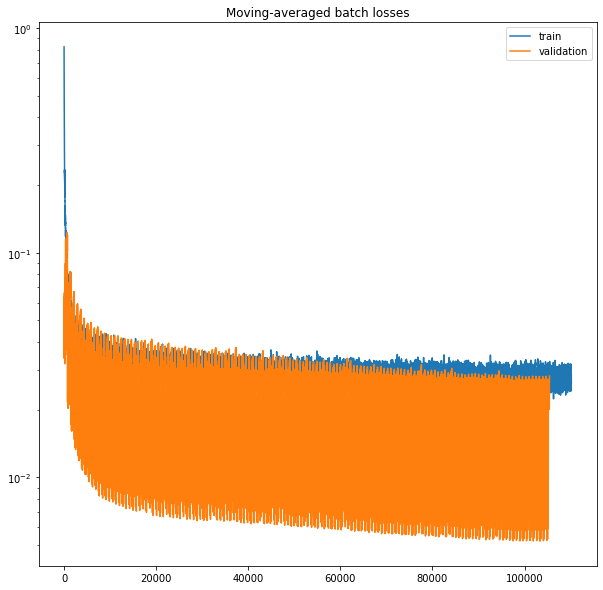

In [31]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [32]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

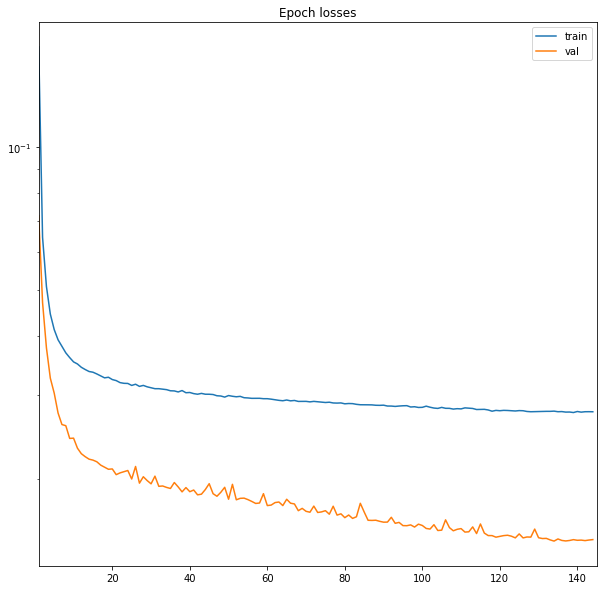

In [33]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [34]:
import pandas as pd

In [35]:
from visualization_utils import make_df

In [36]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.995580,0.968229,0.974155,0.971183,0.997500,0.943981,carb96558,basic
1,0.987854,0.915348,0.983751,0.948318,0.993085,0.901715,carb71,basic
2,0.974144,0.943219,0.838279,0.887659,0.969924,0.798009,carbRNF,basic
3,0.993122,0.995582,0.914806,0.953487,0.996802,0.911108,SPE_carb10_58_box3,basic
4,0.991596,0.985227,0.914948,0.948788,0.994163,0.902565,SoilAh-1,basic
5,0.994961,0.967195,0.959671,0.963418,0.995441,0.929419,SoilB-2,basic
6,0.989245,0.996568,0.922707,0.958216,0.997507,0.919784,TeTree_subset1,basic
7,0.992727,0.996808,0.936994,0.965976,0.998333,0.934191,TiTree_subset2,basic
8,0.991257,0.962216,0.963094,0.962655,0.995706,0.927998,Urna_22,basic
9,0.989738,0.969067,0.972537,0.970799,0.997396,0.943255,Urna_30,basic


In [37]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.90969
Std    IOU: 0.040677
Min    IOU: 0.79801
Median IOU: 0.91978
